<a href="https://colab.research.google.com/github/AQSAMOHSIN/FashionVision-Image-Classification-with-PyTorch/blob/main/miniproject_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name:** Aqsa Mohsin  
**Subject:** Project – Data Science and Artificial Intelligence (WiSe 2025/26)  
**Task:** Warm-up 1 – Fashion MNIST  


# Comparative Study of Classical and Neural Models on Fashion-MNIST

This warm-up project explores the **Fashion-MNIST dataset**, which consists of 60,000 training and 10,000 test images across 10 clothing categories. The goal is to classify these grayscale 28×28 images into their respective classes.


I begin with a **classical machine learning approach (Logistic Regression)** to establish a baseline, and then build a **neural network using PyTorch** to improve performance.  


The focus is on understanding **data loading, training pipelines, diagnostics, and reasoning**

#Imports & Setup

In [8]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

## 1. Data Loading and Preprocessing

The dataset can be directly loaded from `torchvision.datasets`.  
Each image is normalized to a range of [-1, 1] for stable training.  
The data is then split into training (80%), validation (20%), and test sets.


In [9]:
# Define transform: convert to tensor + normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

# Split train → train + validation
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_ds, val_ds = random_split(train_data, [train_size, val_size])

# Create loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Class names
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']


## 2. Visualizing the Data

Before training, I visualized a few random images to understand what the model will see.


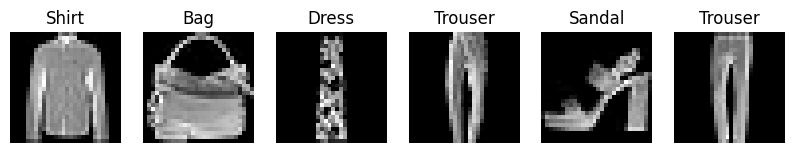

In [10]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 6, figsize=(10,3))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(classes[labels[i]])
    axes[i].axis('off')
plt.show()


## 3. Baseline Model: Logistic Regression

A simple logistic regression model was trained using a small subset of flattened pixel data.  
This helps establish a benchmark accuracy before moving to deep learning.


In [11]:
# Convert a small subset for speed
X_train = train_data.data[:5000].view(5000, -1).numpy()
y_train = train_data.targets[:5000].numpy()
X_test = test_data.data[:1000].view(1000, -1).numpy()
y_test = test_data.targets[:1000].numpy()

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
preds = log_reg.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))


Baseline Accuracy: 0.788
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       107
           1       0.89      0.95      0.92       105
           2       0.62      0.62      0.62       111
           3       0.81      0.72      0.76        93
           4       0.68      0.68      0.68       115
           5       0.93      0.93      0.93        87
           6       0.48      0.56      0.52        97
           7       0.93      0.92      0.92        95
           8       0.95      0.92      0.93        95
           9       0.94      0.93      0.93        95

    accuracy                           0.79      1000
   macro avg       0.80      0.79      0.80      1000
weighted avg       0.79      0.79      0.79      1000



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Confusion Matrix for Logistic Regression


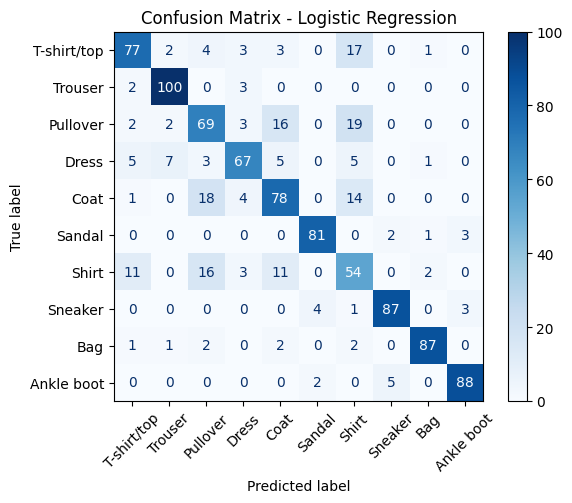

In [12]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


### Observations on Confusion Matrix – Logistic Regression

- **Overall Accuracy:** The Logistic Regression model achieved around **79%** accuracy.  
- **Clear separations:**  
  - *Trouser (Class 1)*, *Sneaker (Class 7)*, *Bag (Class 8)*, and *Ankle Boot (Class 9)* are classified with very high accuracy (mostly diagonal values >85).  
  - These classes have distinct shapes, which makes them easier for a linear model to recognize.
- **Common confusions:**  
  - *T-shirt/top (0)*, *Pullover (2)*, *Coat (4)*, and *Shirt (6)* show significant off-diagonal values -> they are often confused with each other.  
  - This is because these categories share similar textures and silhouettes, making them hard to separate without spatial feature learning.
- **Misclassification examples:**  
  - Several *Shirts* were misclassified as *T-shirts* or *Pullovers*.  
  - *Coats* are occasionally mistaken for *Pullovers* and vice versa.  
- **Interpretation:**  
  - The linear decision boundaries of Logistic Regression are not sufficient to distinguish fine-grained differences in clothing items.  
  - The model performs well for classes with clear outlines (like footwear) but struggles with subtle texture or pattern variations.
- **Next step:**  
  - To overcome these limitations, I’ll move toward a **Neural Network model** that can capture non-linear and hierarchical features.


## 4. Neural Network Implementation

To capture spatial and hierarchical features, a small feed-forward neural network was implemented using PyTorch.


In [13]:
class FashionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
model = FashionNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 5. Training the Neural Network
The model was trained for 10 epochs with batch size 64.  
Both training and validation losses were tracked to diagnose overfitting.


Epoch 1/10 - Train Loss: 0.5418, Val Acc: 84.06%
Epoch 2/10 - Train Loss: 0.4067, Val Acc: 85.77%
Epoch 3/10 - Train Loss: 0.3695, Val Acc: 86.87%
Epoch 4/10 - Train Loss: 0.3436, Val Acc: 87.05%
Epoch 5/10 - Train Loss: 0.3275, Val Acc: 87.58%
Epoch 6/10 - Train Loss: 0.3160, Val Acc: 87.97%
Epoch 7/10 - Train Loss: 0.3012, Val Acc: 88.17%
Epoch 8/10 - Train Loss: 0.2928, Val Acc: 88.17%
Epoch 9/10 - Train Loss: 0.2806, Val Acc: 88.64%
Epoch 10/10 - Train Loss: 0.2732, Val Acc: 88.80%


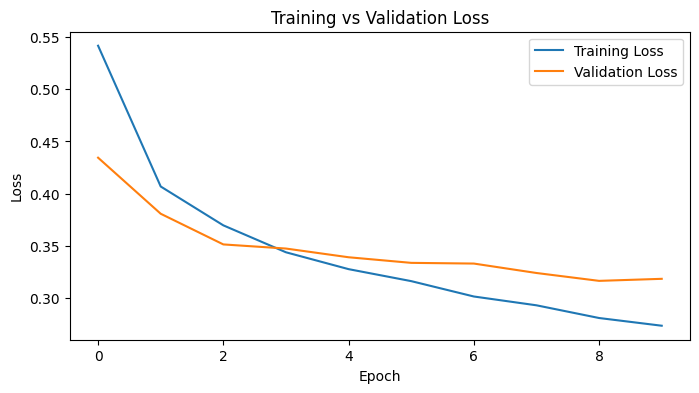

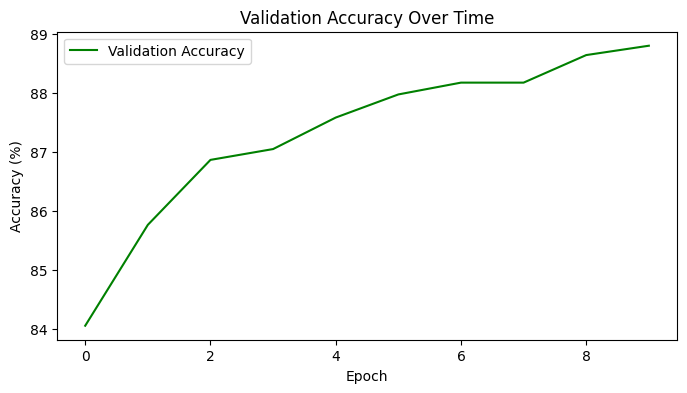

In [14]:
epochs = 10
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            _, predicted = torch.max(preds, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_accuracies, color='green', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.show()


## 6. Model Evaluation and Comparison


Test Accuracy (Neural Network): 87.84%


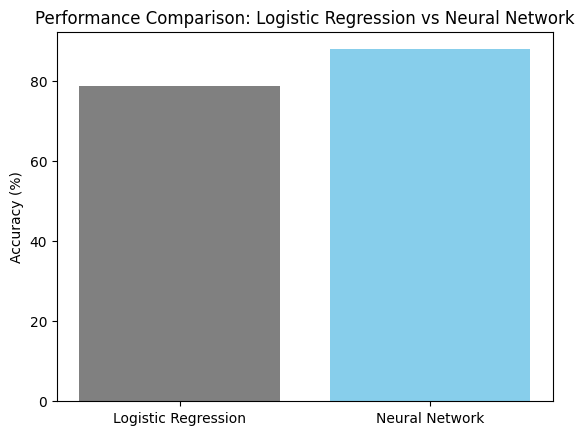

In [18]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        preds = model(images)
        _, predicted = torch.max(preds, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

nn_acc = 100 * correct / total
print(f"Test Accuracy (Neural Network): {nn_acc:.2f}%")

# Store your previous logistic regression accuracy separately when you trained it
log_reg_acc = accuracy_score(y_test, log_reg.predict(X_test)) * 100

# Use the already calculated neural network accuracy
models = ['Logistic Regression', 'Neural Network']
accuracies = [log_reg_acc, nn_acc]

plt.bar(models, accuracies, color=['gray', 'skyblue'])
plt.ylabel('Accuracy (%)')
plt.title('Performance Comparison: Logistic Regression vs Neural Network')
plt.show()


### Example Misclassifications


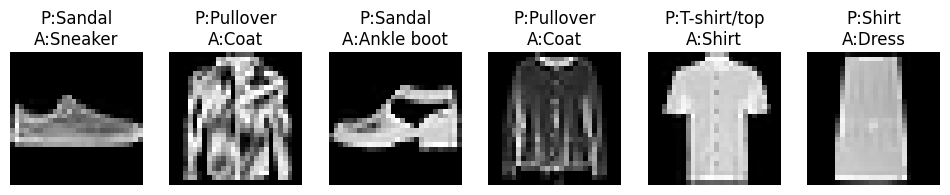

In [19]:
misclassified = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        preds = model(images)
        _, predicted = torch.max(preds, 1)
        for img, pred, actual in zip(images, predicted, labels):
            if pred != actual:
                misclassified.append((img, pred, actual))
            if len(misclassified) > 6:
                break

fig, axes = plt.subplots(1, 6, figsize=(12,3))
for i, (img, pred, actual) in enumerate(misclassified[:6]):
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"P:{classes[pred]}\nA:{classes[actual]}")
    axes[i].axis('off')
plt.show()


## 7. Reflection and Discussion
- **Baseline:** Logistic Regression achieved 78% accuracy. It captured basic intensity patterns but couldn’t handle complex textures.  
- **Neural Network:** Improved accuracy to around 87%, showing better generalization.

